In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'first',
    'second',
    'third'
]
docName = "testDoc"

# load seq data
data = np.concatenate([
    np.load("dataset/seq_{}_first.npy".format(docName)),
    np.load("dataset/seq_{}_second.npy".format(docName)),
    np.load("dataset/seq_{}_third.npy".format(docName))
], axis=0)

data.shape
# 총 데이터셋 개수, 윈도우 사이즈, 한 윈도우 당 데이터 개수 일케 뜰겨

(804, 30, 100)

In [3]:
# 마지막 값 라벨이므로 빼주고 x데이터 만듦
x_data = data[:, :, :-1]

# 마지막값만 가지고 라벨로 만듦
labels = data[:, 0, -1]


label_dict = {label: i for i, label in enumerate(actions)}
labels = np.array([label_dict[label] for label in labels])

print(x_data.shape)
print(labels.shape)
# 윈도우 당 데이터 00로 줄어들겨
# 라벨 개수 (총 데이터 수랑 같은 개수) 나올겨

(804, 30, 99)
(804,)


In [4]:
from tensorflow.keras.utils import to_categorical

# 라벨 0이면 [1,0,0], 라벨 1이면 [0,1,0] 이렇게 만드는 원핫인코딩 할겨
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

2023-05-12 20:20:57.964392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(804, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 90퍼 -> 트레이닝 셋, 10퍼 -> 테스트셋으로 만듦
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(723, 30, 99) (723, 3)
(81, 30, 99) (81, 3)


In [6]:
# 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM과 Dense 2개 연결
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


2023-05-12 20:21:02.622811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# 학습
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# model.fit 해서 학습. 200번 epochs 돌려
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)
# 정확도 높은 모델 따로 저장할겨

Epoch 1/200
19/23 [=======================>......] - ETA: 0s - loss: 13.8017 - acc: 0.5510
Epoch 1: val_acc improved from -inf to 0.64198, saving model to models/model.h5
23/23 [==============================] - 1s 20ms/step - loss: 12.8518 - acc: 0.5712 - val_loss: 14.2954 - val_acc: 0.6420 - lr: 0.0010
Epoch 2/200
19/23 [=======================>......] - ETA: 0s - loss: 7.7150 - acc: 0.7928
Epoch 2: val_acc improved from 0.64198 to 0.90123, saving model to models/model.h5
23/23 [==============================] - 0s 10ms/step - loss: 7.7972 - acc: 0.7981 - val_loss: 5.3320 - val_acc: 0.9012 - lr: 0.0010
Epoch 3/200
19/23 [=======================>......] - ETA: 0s - loss: 3.5030 - acc: 0.8207
Epoch 3: val_acc did not improve from 0.90123
23/23 [==============================] - 0s 10ms/step - loss: 3.7450 - acc: 0.8064 - val_loss: 6.4874 - val_acc: 0.5926 - lr: 0.0010
Epoch 4/200
20/23 [=========================>....] - ETA: 0s - loss: 3.7632 - acc: 0.7453
Epoch 4: val_acc did not impr

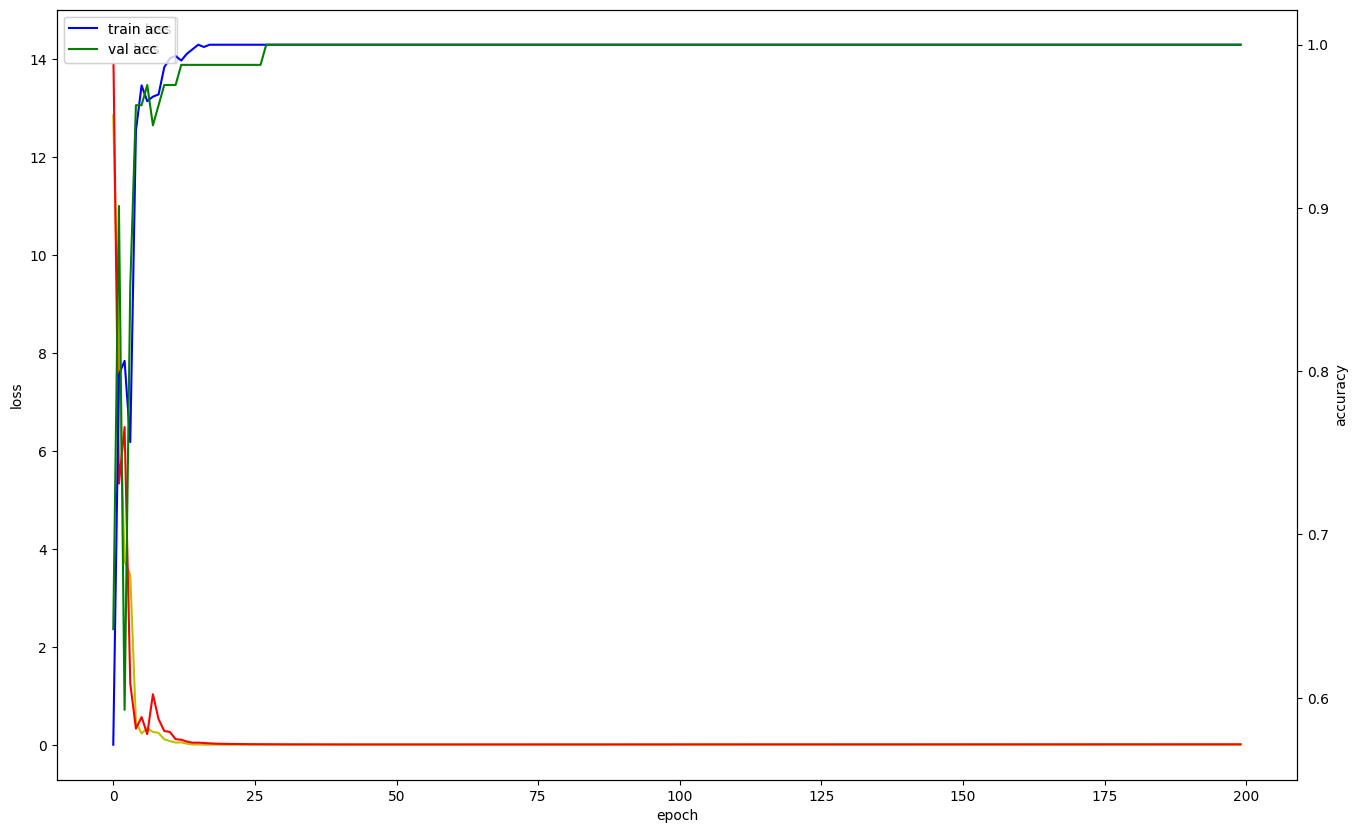

In [8]:
# 학습 완료 그래프
# 초파 -> train acc, val acc
# 노빨 -> loss
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# 저장한 모델 로드
model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[47,  0],
        [ 0, 34]],

       [[63,  0],
        [ 0, 18]],

       [[52,  0],
        [ 0, 29]]])

3/3 [==============================] - 0s 3ms/step


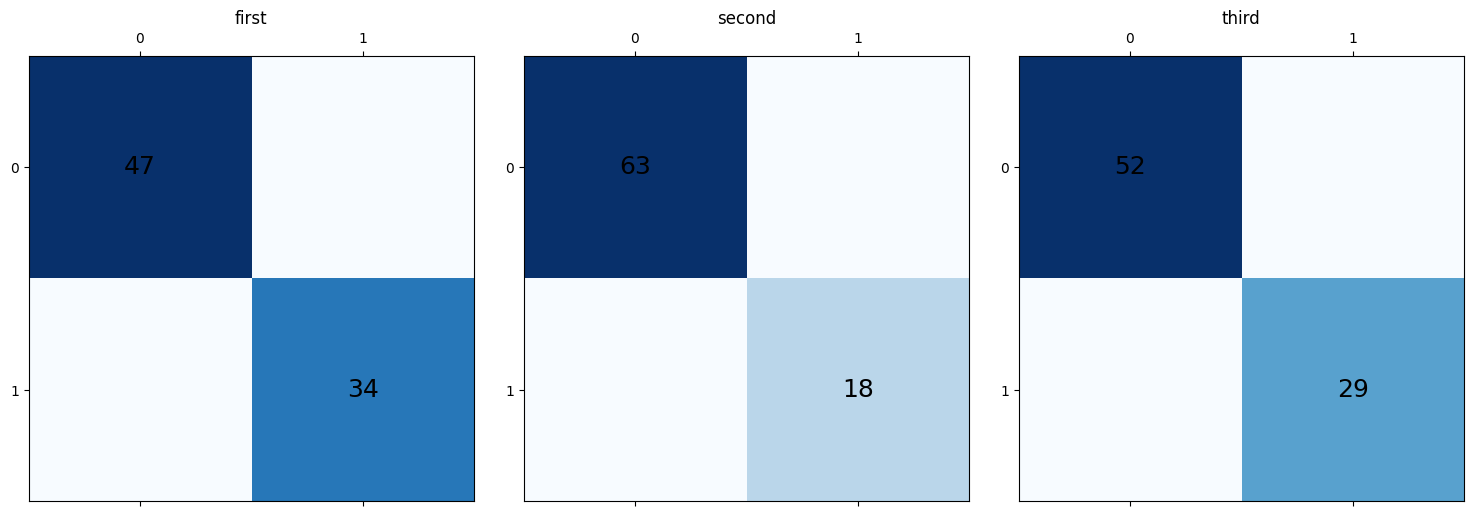

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(confusion_matrix, class_names):
    fig, axes = plt.subplots(nrows=1, ncols=len(confusion_matrix), figsize=(15, 5))
    for i, matrix in enumerate(confusion_matrix):
        ax = axes[i]
        ax.matshow(matrix, cmap=plt.cm.Blues)
        ax.set(title=actions[i])
        for j in range(matrix.shape[0]):
            ax.text(x=j, y=j, s=matrix[j, j], va='center', ha='center', fontsize=18)
            
    plt.tight_layout()
    plt.show()

y_pred = model.predict(x_val)
confusion_matrix = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(confusion_matrix, class_names=["Class 0", "Class 1", "Class 2"])


3/3 [==============================] - 0s 4ms/step


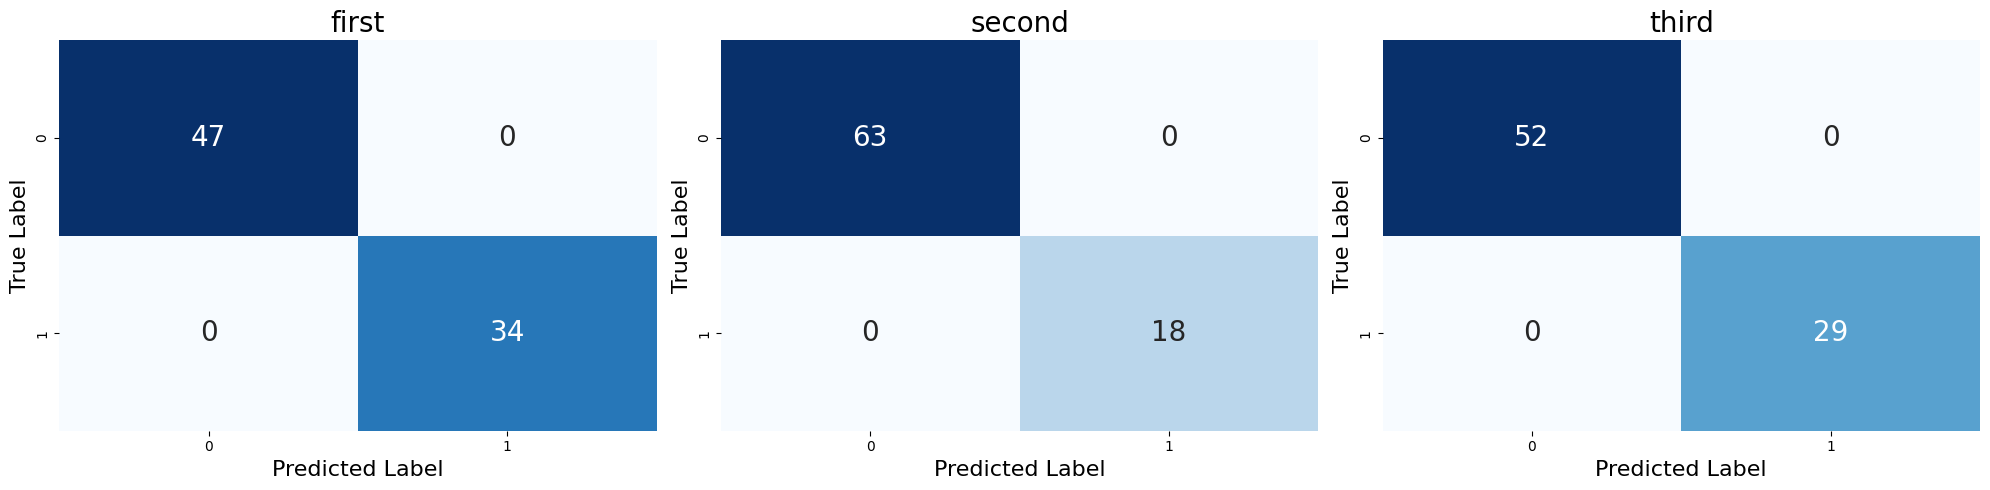

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# 모델 예측
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Confusion Matrix 생성
cm = multilabel_confusion_matrix(y_val_classes, y_pred_classes)

# Confusion Matrix 시각화
fig, axs = plt.subplots(1, len(cm), figsize=(20, 5))

for i in range(len(cm)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize":20}, ax=axs[i], cbar=False)
    axs[i].set_title(actions[i], fontsize=20)
    axs[i].set_xlabel("Predicted Label", fontsize=16)
    axs[i].set_ylabel("True Label", fontsize=16)
    

plt.tight_layout()
plt.show()


3/3 [==============================] - 0s 4ms/step


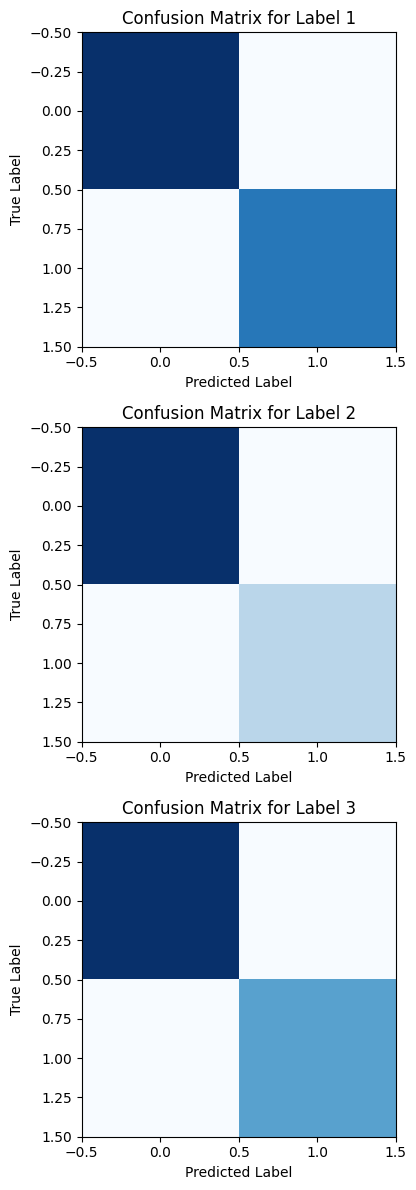

In [26]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

model = load_model('models/model.h5')

y_pred = model.predict(x_val)
cm = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(cm[i], cmap='Blues', interpolation='nearest')
    # ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[2]),
        #    xticklabels=['pred:0', 'pred:1'], yticklabels=['true:0', 'true:1'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix for Label {i+1}')

plt.tight_layout()
plt.show()
